<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Recommender%20Systems/PyTorch_Recommender_20M_UNMODIFIED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.utils import shuffle

In [2]:
# data is from: https://grouplens.org/datasets/movielens/
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2022-10-22 18:04:37--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  13.6MB/s    in 16s     

2022-10-22 18:04:54 (12.0 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
!ls

ml-20m	ml-20m.zip  sample_data


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#     global current_user_id, custom_user_map
#     old_user_id = row['userId']
#     if old_user_id not in custom_user_map:
#         custom_user_map[old_user_id] = current_user_id
#         current_user_id += 1
#     return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [7]:
# Now do the same for movieId

# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#     global current_movie_id, custom_movie_map
#     old_movie_id = row['movieId']
#     if old_movie_id not in custom_movie_map:
#         custom_movie_map[old_movie_id] = current_movie_id
#         current_movie_id += 1
#     return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [8]:
# Get user IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [9]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [10]:
# Make the neural network
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim
        
        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)
        
    def forward(self, u, m):
        u = self.u_emb(u) # output is (num_samples, D)
        m = self.m_emb(m) # output is (num_samples, D)
        
        # merge
        out = torch.cat((u, m), 1) # output is (num_samples, 2D)
        
        # ANN
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [12]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [13]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [15]:
# convert to tensors
user_ids_t = torch.from_numpy(user_ids).long()
movie_ids_t = torch.from_numpy(movie_ids).long()
ratings_t = torch.from_numpy(ratings)

In [16]:
# Make dataset
Ntrain = int(0.8 * len(ratings))
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain], 
    movie_ids_t[:Ntrain], 
    ratings_t[:Ntrain]
)

test_dataset = torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:], 
    movie_ids_t[Ntrain:], 
    ratings_t[Ntrain:]
)

In [17]:
# Data loader
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [18]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        t0 = datetime.datetime.now()
        train_loss = []
        for users, movies, targets in train_loader:
            targets = targets.view(-1, 1).float()
            
            # move data to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
        
        test_loss = []
        for users, movies, targets in test_loader:
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        
        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [19]:
# profile this using
%prun train_losses, test_losses = batch_gd( \
    model, criterion, optimizer, train_loader, test_loader, 25)

Epoch 1/25, Train Loss: 0.8188, Test Loss: 0.7537, Duration: 0:04:42.126662
Epoch 2/25, Train Loss: 0.7400, Test Loss: 0.7382, Duration: 0:04:37.780068
Epoch 3/25, Train Loss: 0.7244, Test Loss: 0.7254, Duration: 0:04:37.496256
Epoch 4/25, Train Loss: 0.7089, Test Loss: 0.7120, Duration: 0:04:38.343103
Epoch 5/25, Train Loss: 0.6954, Test Loss: 0.7038, Duration: 0:04:38.353589
Epoch 6/25, Train Loss: 0.6866, Test Loss: 0.6992, Duration: 0:04:37.748130
Epoch 7/25, Train Loss: 0.6807, Test Loss: 0.6940, Duration: 0:04:38.705172
Epoch 8/25, Train Loss: 0.6763, Test Loss: 0.6922, Duration: 0:04:38.293989
Epoch 9/25, Train Loss: 0.6727, Test Loss: 0.6905, Duration: 0:04:38.085836
Epoch 10/25, Train Loss: 0.6697, Test Loss: 0.6896, Duration: 0:04:38.908021
Epoch 11/25, Train Loss: 0.6670, Test Loss: 0.6912, Duration: 0:04:38.265616
Epoch 12/25, Train Loss: 0.6645, Test Loss: 0.6871, Duration: 0:04:40.950078
Epoch 13/25, Train Loss: 0.6623, Test Loss: 0.6869, Duration: 0:04:39.512030
Epoch 14

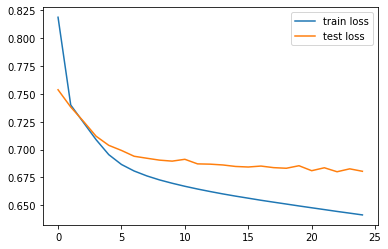

In [20]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()